# Naive

This model just repeats the observation from $k$ steps before, i.e. 
$\hat{y}_{t+k} = y_t$.

## 1. Loading the data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities.datatools import create_timestamps

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load actual generation data
df_observed = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Load generation forecasts (needed for Forecaster infrastructure)
df_forecasts = pd.read_csv(
    os.path.join(data_dir, "neso_forecasts.csv"),
    parse_dates=["TARGET_DATE", "ISSUE_DATE"],
)

if df_observed.isna().values.any():
    print("Warning: BMRS dataset contains null values.")

if df_forecasts.isna().values.any():
    print("Warning: NESO dataset contains null values.")

Convert settlement dates and periods to timestamps:

In [2]:
df_observed["TIMESTAMP"] = create_timestamps(
    df_observed,
    date_column="SETTLEMENT_DATE",
    period_column="SETTLEMENT_PERIOD",
    tz="UTC"
)
df_observed = df_observed.drop(columns=["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

df_forecasts["TIMESTAMP"] = create_timestamps(
    df_forecasts,
    date_column="TARGET_DATE",
    period_column="TARGET_PERIOD",
    tz="UTC",
)
df_forecasts = df_forecasts.drop(columns=["TARGET_DATE", "TARGET_PERIOD"])

Set `DatetimeIndex`:

In [3]:
df_train = df_observed.rename(columns={"INDO": "DEMAND"})
df_train = df_train.set_index("TIMESTAMP")
df_train.index = df_train.index.round('30min')
df_train = df_train.asfreq('30min')

df_test = df_forecasts.set_index("TIMESTAMP")
df_test.index = df_test.index.round('30min')
df_test = df_test.asfreq('30min')

df_train.head()

,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,DEMAND,ITSO,ELECTRICITY_PRICE,TRADING_VOLUME
TIMESTAMP,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30
2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40
2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00
2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35
2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40


## 2. Feature engineering

In [4]:
df_train = df_train[["ELECTRICITY_PRICE"]]
df_test = df_test[[]]  # Keep only DatetimeIndex

## 3. Make a point forecast

Train-test split:

In [5]:
import datetime

train_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=1),
    end=datetime.date(year=2024, month=11, day=7),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

test_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=7),
    end=datetime.date(year=2024, month=11, day=8),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

endog_train = df_train.loc[train_dates, "ELECTRICITY_PRICE"]
endog_test = df_train.loc[test_dates, "ELECTRICITY_PRICE"]

Specify and fit model:

In [6]:
k = 48  # Repeat last day's observations

# Store last k observations as the "fitted model"
observations = endog_train.iloc[-k:]

# Training residuals: y[t] - y[t-k]
train_resid = endog_train.values[k:] - endog_train.values[:-k]

Plot residuals from training:

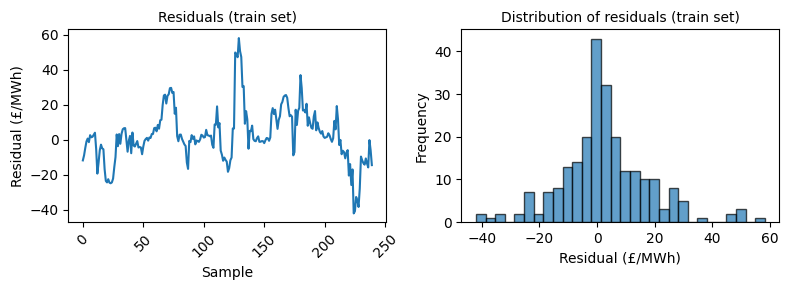

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(train_resid, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("Residuals (train set)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(train_resid, bins=30, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of residuals (train set)", fontsize=10)
plt.show()

ACF/PACF of training residuals:

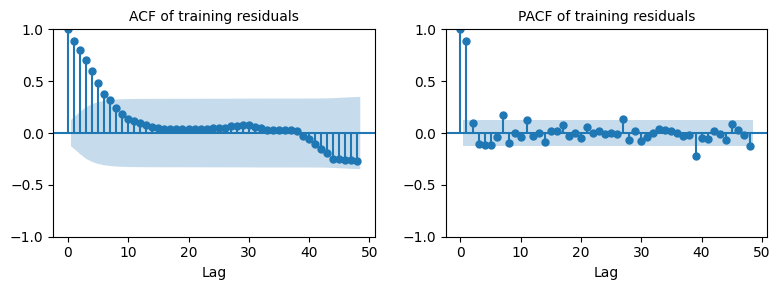

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(train_resid, lags=48, ax=ax1)
ax1.set_title("ACF of training residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

plot_pacf(train_resid, lags=48, ax=ax2)
ax2.set_title("PACF of training residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

Make a forecast:

In [9]:
from utilities.evaluation import rmse, mae

n_test = len(endog_test)
point_forecast = pd.Series(
    observations.values[np.arange(n_test) % k],
    index=endog_test.index
)

print(f"RMSE: {rmse(np.asarray(point_forecast), np.asarray(endog_test)):.2f} £/MWh")
print(f"MAE: {mae(np.asarray(point_forecast), np.asarray(endog_test)):.2f} £/MWh")

RMSE: 22.21 £/MWh
MAE: 18.32 £/MWh


Visualise results:

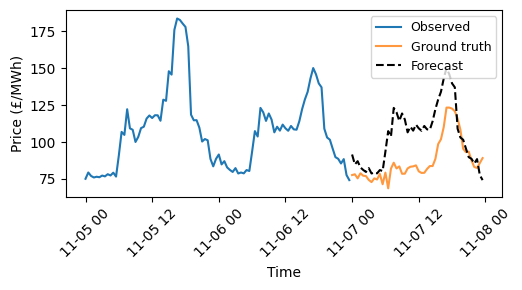

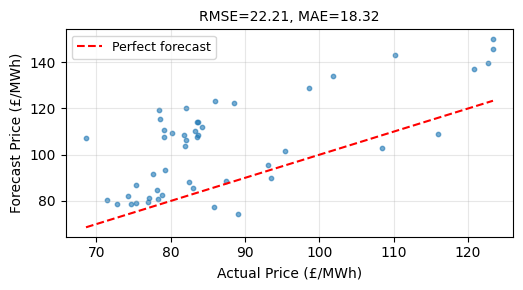

In [10]:
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(endog_train.iloc[-(2 * n_test):], label="Observed")
ax.plot(endog_test, label="Ground truth", alpha=0.8)
ax.plot(point_forecast, ls="--", color="k", label="Forecast")
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.tick_params(axis="x", labelrotation=45)
ax.legend(fontsize=9)
plt.show()

y_pred = np.asarray(point_forecast)
y_true = np.asarray(endog_test)
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)

fig, ax = plt.subplots(figsize=(16 / 3, 3), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10)
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--", label="Perfect forecast",
)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

Study the residuals of the forecast:

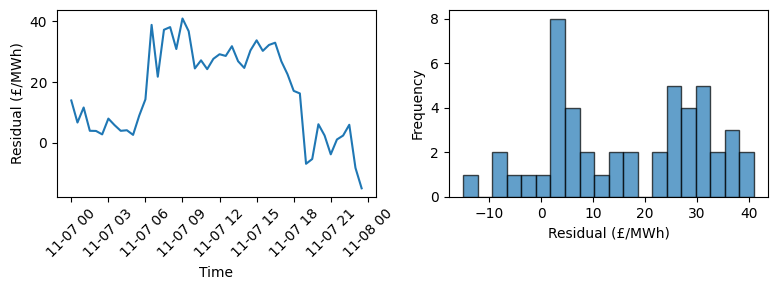

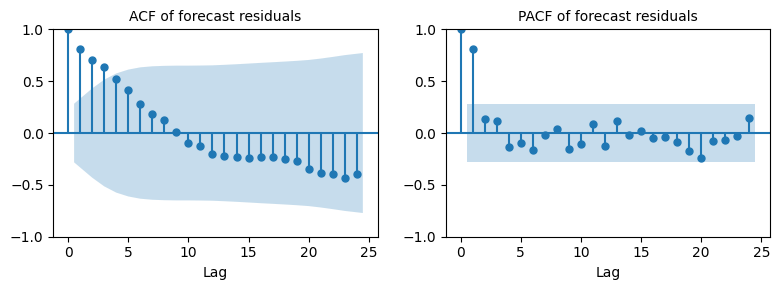

In [11]:
resi = point_forecast - endog_test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")

ax1.plot(resi)
ax1.set_xlabel("Time", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(resi, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(resi, lags=24, ax=ax1)
ax1.set_title("ACF of forecast residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

plot_pacf(resi, lags=24, ax=ax2)
ax2.set_title("PACF of forecast residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

### 3.1 Bootstrapping the residuals of the point forecast

Validate that sieve bootstrapping is an acceptable method:


Mean of sieve residuals: 0.000000
Standard deviation of sieve residuals: 6.54


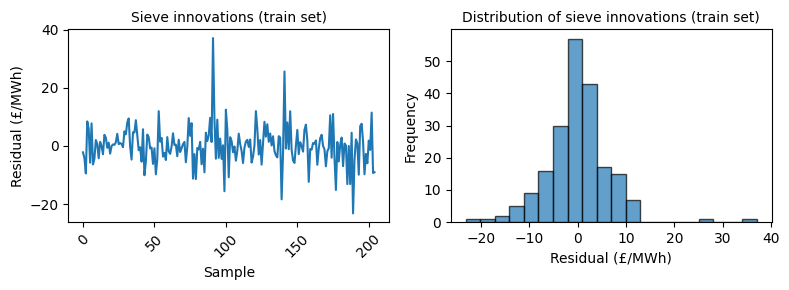

In [12]:
import statsmodels.api as sm

# Fit AR(p) sieve model to residuals
n = len(resi)
p_sieve = int(n / np.log(n) ** (1 / 4)) + 1
sieve_model = sm.tsa.AutoReg(train_resid, lags=p_sieve, old_names=False)
sieve_fitted = sieve_model.fit()

# Get innovations (epsilon_k) from sieve and center them
sieve_resid = sieve_fitted.resid
epsilon_centered = sieve_resid - sieve_resid.mean()
print(f"\nMean of sieve residuals: {sieve_resid.mean():.6f}")
print(f"Standard deviation of sieve residuals: {sieve_resid.std():.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(epsilon_centered, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("Sieve innovations (train set)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(epsilon_centered, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of sieve innovations (train set)", fontsize=10)
plt.show()

In [13]:
from utilities.bootstrap import cond_sieve_bootstrap

n_bootstrap = 500

bootstrap_paths = cond_sieve_bootstrap(
    train_resid, np.asarray(point_forecast), n_bootstrap, seed=0
)

ci_lower = np.percentile(bootstrap_paths, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_paths, 97.5, axis=0)
ci_median = np.percentile(bootstrap_paths, 50, axis=0)
print(f"Bootstrap completed with {n_bootstrap} samples")
print(f"Mean CI width: {np.mean(ci_upper - ci_lower):.2f} £/MWh")

Bootstrap completed with 500 samples
Mean CI width: 58.52 £/MWh


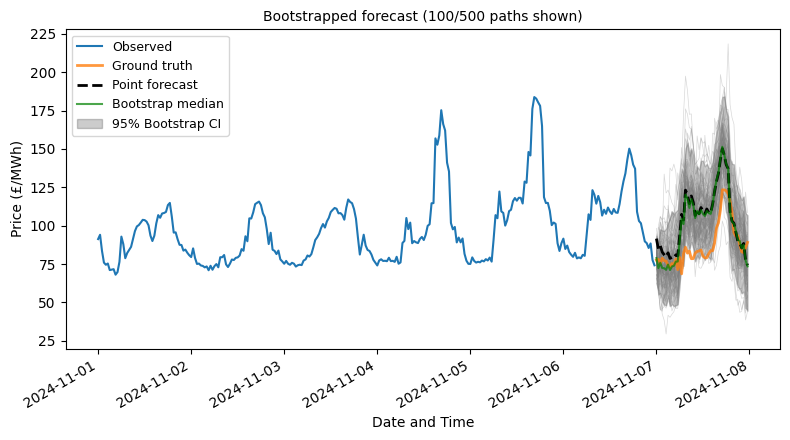

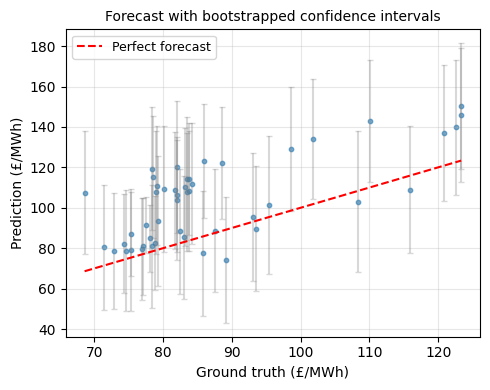

In [14]:
fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="tight")

n_sample = 100
for b in range(n_sample):
    ax.plot(
        endog_test.index,
        bootstrap_paths[b, :],
        color="gray",
        alpha=0.3,
        linewidth=0.5,
    )

ax.plot(endog_train, label="Observed", color="C0")
ax.plot(endog_test, label="Ground truth", color="C1", linewidth=2, alpha=0.8)
ax.plot(point_forecast, "k--", label="Point forecast", linewidth=2)

ax.plot(
    endog_test.index, ci_median,
    "g-", label="Bootstrap median", linewidth=1.5, alpha=0.7,
)
ax.fill_between(
    endog_test.index, ci_lower, ci_upper,
    color="k", alpha=0.2, label="95% Bootstrap CI",
)
ax.set_xlabel("Date and Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(
    f"Bootstrapped forecast ({n_sample}/{n_bootstrap} paths shown)",
    fontsize=10,
)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=30, ha="right")
plt.show()

fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10)
ci_half_width = (ci_upper - ci_lower) / 2
ax.errorbar(
    endog_test, point_forecast, yerr=ci_half_width,
    fmt="none", ecolor="gray", alpha=0.3, capsize=2,
)

ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--",
    label="Perfect forecast",
)

ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.set_title("Forecast with bootstrapped confidence intervals", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 4. Rolling day-ahead forecast evaluation

We now implement a rolling forecast where we:
1. Fit the model on a window of historical data
2. Forecast the prices for the day ahead
3. Bootstrap the residuals to get confidence intervals
4. Update the model with latest observations
5. Move on to the next day and repeat

In [15]:
from utilities.forecast import Forecaster


class NaiveForecaster(Forecaster):
    """Day-ahead forecaster using the naive method (repeat last k observations)."""

    def __init__(self, *, k=48, **kwargs):
        super().__init__(**kwargs)
        self._k = k
        self._observations = None
        self._residuals = None

    def _fit(self, endog, exog=None):
        self._observations = endog.iloc[-self._k:]
        vals = endog.values
        self._residuals = vals[self._k:] - vals[:-self._k]

    def _forecast_steps(self, steps, exog=None):
        obs = self._observations.values
        return obs[np.arange(steps) % self._k]

    def _get_residuals(self):
        return self._residuals

In [16]:
# Rolling forecast parameters
n_train_samples = 48 * 7  # 1 week of training data
forecast_days = 7  # Number of day-ahead forecasts
n_bootstrap = 500  # Bootstrap samples per forecast

print("Rolling forecast configuration:")
print(f"  Training set size: {n_train_samples} samples")
print(f"  Forecast days: {forecast_days}")
print(f"  Bootstrap samples: {n_bootstrap}")

# Create issue times (period 18 = 08:30 London time)
start_time = pd.Timestamp("2024-11-01 08:30", tz="Europe/London")
end_time = start_time + pd.Timedelta(days=forecast_days)
issue_times = pd.date_range(start_time, end_time, freq="D")

print("\nTimestamps at which forecasts are issued:")
print(f"  First: {issue_times[0]}")
print(f"  Last: {issue_times[-1]}")
print(f"  Total: {len(issue_times)} days")

print("\nModel specification:")
print(f"  Periodicity: {48}")

Rolling forecast configuration:
  Training set size: 336 samples
  Forecast days: 7
  Bootstrap samples: 500

Timestamps at which forecasts are issued:
  First: 2024-11-01 08:30:00+00:00
  Last: 2024-11-08 08:30:00+00:00
  Total: 8 days

Model specification:
  Periodicity: 48


In [17]:
forecaster = NaiveForecaster(k=48)

print("Running rolling forecast...")
results = forecaster.rolling_forecast_dayahead(
    df_train,
    df_test,
    issue_times,
    n_train_samples,
    percentiles=[2.5, 97.5],
    n_bootstrap=n_bootstrap,
)

# Summary statistics
rmse_val = np.sqrt(np.mean((results["forecast"] - results["actual"]) ** 2))
in_ci = (results["actual"] >= results["p2.5"]) & (
    results["actual"] <= results["p97.5"]
)
coverage = in_ci.mean() * 100

print("\n" + "=" * 50)
print("RESULTS SUMMARY")
print("=" * 50)
print(f"Total forecasts: {len(results)} periods")
print(f"RMSE: {rmse_val:.2f} £/MWh")
print(f"95% CI Coverage: {coverage:.1f}%")
print(
    f"Mean CI width: {(results['p97.5'] - results['p2.5']).mean():.2f} £/MWh"
)

Running rolling forecast...
[1/8] Forecasting from 2024-11-01 08:30:00+00:00
  RMSE: 11.04, MAE: 7.91
[2/8] Forecasting from 2024-11-02 08:30:00+00:00
  RMSE: 13.20, MAE: 8.99
[3/8] Forecasting from 2024-11-03 08:30:00+00:00
  RMSE: 20.48, MAE: 13.36
[4/8] Forecasting from 2024-11-04 08:30:00+00:00
  RMSE: 15.15, MAE: 12.33
[5/8] Forecasting from 2024-11-05 08:30:00+00:00
  RMSE: 16.09, MAE: 11.77
[6/8] Forecasting from 2024-11-06 08:30:00+00:00
  RMSE: 22.21, MAE: 18.32
[7/8] Forecasting from 2024-11-07 08:30:00+00:00
  RMSE: 28.46, MAE: 23.04
[8/8] Forecasting from 2024-11-08 08:30:00+00:00
  RMSE: 19.49, MAE: 14.93

RESULTS SUMMARY
Total forecasts: 384 periods
RMSE: 19.00 £/MWh
95% CI Coverage: 88.8%
Mean CI width: 63.45 £/MWh


Visualise results:

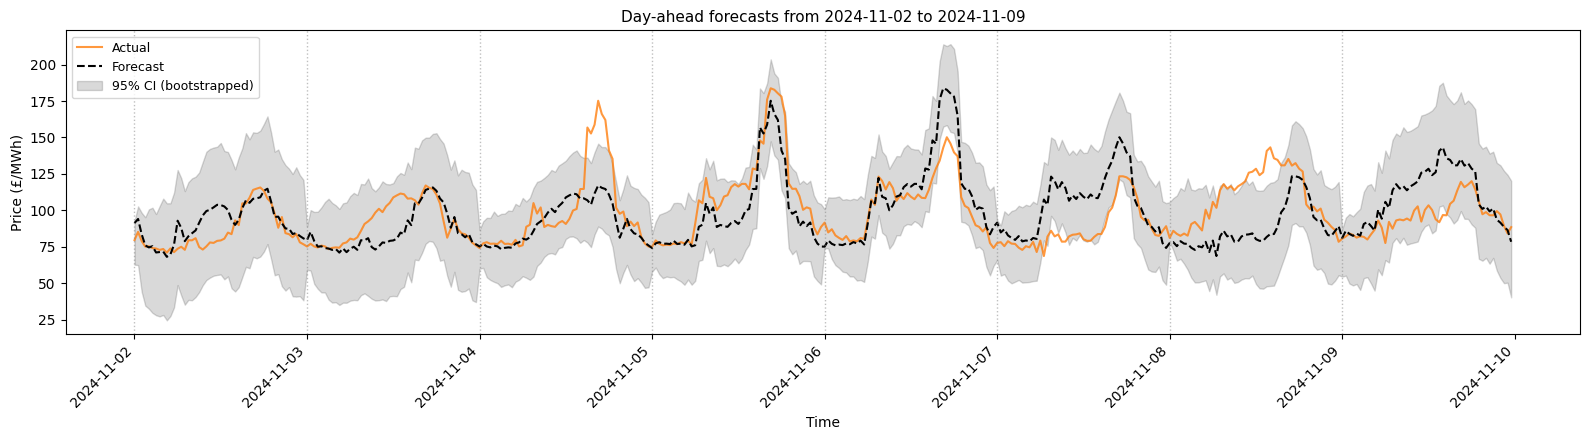

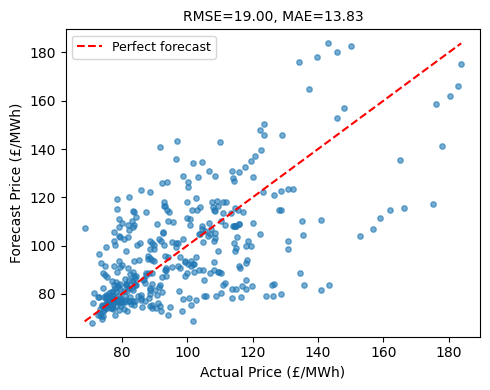

In [18]:
from utilities.evaluation import mae, rmse

ts = results.index

# Main time series plot with day boundaries
fig, ax = plt.subplots(figsize=(16, 9 / 2), layout="tight")
ax.plot(ts, results["actual"], "C1", label="Actual", linewidth=1.5, alpha=0.8)
ax.plot(ts, results["forecast"], "k--", label="Forecast", linewidth=1.5)

# Confidence intervals
ax.fill_between(
    ts, results["p2.5"], results["p97.5"],
    color="k", alpha=0.15, label="95% CI (bootstrapped)",
)

# Add vertical lines at midnight (day boundaries)
unique_dates = ts.normalize().unique()
for midnight in unique_dates:
    ax.axvline(midnight, color="gray", linestyle=":", alpha=0.5, linewidth=1)

# Labels and title
date_range = f"{unique_dates[0].date()} to {unique_dates[-1].date()}"
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Day-ahead forecasts from {date_range}", fontsize=11)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=45, ha="right")
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(results["actual"], results["forecast"], alpha=0.6, s=15)
ax.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--",
    label="Perfect forecast",
    linewidth=1.5,
)

y_pred = np.asarray(results["forecast"])
y_true = np.asarray(results["actual"])
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
plt.show()